In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
%cd '/content/gdrive/My Drive/unilm/'

/content/gdrive/.shortcut-targets-by-id/19rY6aGdoyGH5C22rAwdx79e5pwrlXHil/unilm


In [23]:
!pip install seqeval transformers==2.9.0 tensorboardX

In [24]:
%cd "/content/gdrive/My Drive/unilm/layoutlm/examples/seq_labeling/"

/content/gdrive/.shortcut-targets-by-id/19rY6aGdoyGH5C22rAwdx79e5pwrlXHil/unilm/layoutlm/examples/seq_labeling


**preprocessing for custom microsoft annotation tool code**

In [5]:
import os
import sys
import json
from PIL import Image

import argparse
import json
import os

from PIL import Image
from transformers import AutoTokenizer


def bbox_string(box, width, length):
    return (
        str(int(1000 * (box[0] / width)))
        + " "
        + str(int(1000 * (box[1] / length)))
        + " "
        + str(int(1000 * (box[2] / width)))
        + " "
        + str(int(1000 * (box[3] / length)))
    )


def actual_bbox_string(box, width, length):
    return (
        str(box[0])
        + " "
        + str(box[1])
        + " "
        + str(box[2])
        + " "
        + str(box[3])
        + "\t"
        + str(width)
        + " "
        + str(length)
    )

#our custom function
def get_label_by_word(text,bounding_boxes,data_labelling1,width,length):
  for i in data_labelling1['labels']:
      for j in i['value']:
          #checking the word
          if(text == j['text']):               
              #checking the match of the coordinates
              if(sum([round(j['boundingBoxes'][0][0:2][0]*width),round(j['boundingBoxes'][0][0:2][1]*length),round(j['boundingBoxes'][0][4:6][0]*width),round(j['boundingBoxes'][0][4:6][1]*length)])/sum(bounding_boxes[0])<2.5):
                  return i['label']

def convert(args):
    with open(
        os.path.join(args.output_dir, args.data_split + ".txt.tmp"),
        "w",
        encoding="utf8",
    ) as fw, open(
        os.path.join(args.output_dir, args.data_split + "_box.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fbw, open(
        os.path.join(args.output_dir, args.data_split + "_image.txt.tmp"),
        "w",
        encoding="utf8",
    ) as fiw:
        for file in os.listdir(args.data_dir):
          #labelling
          file_path_labelling = os.path.join(args.data_dir, file)
          #OCR
          file_path_OCR = file_path_labelling.replace("Labelling_annotations", "OCR_annotations")
          #reading labeling data
          with open(file_path_labelling, "r", encoding="utf8") as f:
              data_labelling = json.load(f)
          
          #reading OCR data
          with open(file_path_OCR, "r", encoding="utf8") as f:
              data_OCR1 = json.load(f)

          #updating the path
          image_path = file_path_OCR.replace("OCR_annotations", "Image")
          
          image_path = image_path.replace("json", "png")
          file_name = os.path.basename(image_path)
          
          #reading image.
          image = Image.open(image_path)
          width, length = image.size

          

          for i in data_OCR1['analyzeResult']['readResults']:
            for j in i['lines']:
                
                #THE string is getting splitted over here.
                #print("\ntext :- ",j['text'].split(" "))
                word_list = []
                label_list = []
                bounding_box = []
                
                #The word and each coordinates are being seperated over here.
                for k in j['words']:
                    #getting word
                    word = k['text']
                    word_list.append(word)
                    
                    #getting label for particular word
                    label_sub = get_label_by_word(k['text'],[[k['boundingBox'][0:2][0],k['boundingBox'][0:2][1],k['boundingBox'][4:6][0],k['boundingBox'][4:6][1]]],data_labelling,width, length)
                    label_list.append(label_sub)
                    
                    #getting bounding boxes
                    bounding_box.append([k['boundingBox'][0:2][0],k['boundingBox'][0:2][1],k['boundingBox'][4:6][0],k['boundingBox'][4:6][1]])
                
                #handling the special cases.
           #     print("\nThe word list :- ",word_list)
           #     print("\nThe label_list :- ",label_list)
                
                
                #condition 1 :- 
                
                #If we have only one label in the entire string
                if(len(set(label_list))==1):
                    label = label_list[0]
                    words = []
                    for word_index in range(0,len(word_list)):
                        dic_buffer = {}
                        dic_buffer['box'] = bounding_box[word_index]
                        dic_buffer['text'] = word_list[word_index]
                        words.append(dic_buffer)
                    #print("\n The label is this condition 1:- ",label)
                    #print("\n The word is this condition 1:- ",words)
                    



                    #write other logic THE OTHER PART OF CODE
                    words = [w for w in words if w["text"].strip() != ""]
                    if len(words) == 0:
                        continue
                    if label == "other":
                        for w in words:
                            fw.write(w["text"] + "\tO\n")
                            fbw.write(
                                w["text"]
                                + "\t"
                                + bbox_string(w["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                w["text"]
                                + "\t"
                                + actual_bbox_string(w["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                    else:
                        if len(words) == 1:
                            fw.write(words[0]["text"] + "\tS-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(words[0]["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        else:
                            fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(words[0]["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                            for w in words[1:-1]:
                                fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(w["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                            fw.write(words[-1]["text"] + "\tE-" + label.upper() + "\n")
                            fbw.write(
                                words[-1]["text"]
                                + "\t"
                                + bbox_string(words[-1]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[-1]["text"]
                                + "\t"
                                + actual_bbox_string(words[-1]["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                    fw.write("\n")
                    fbw.write("\n")
                    fiw.write("\n")
                
                #condition 2 :- 
                
                #If we have multiple label in the string where there is some label called others
                elif(("other" in label_list) or ("others" in label_list) or ("Other" in label_list) or ("Others" in label_list)):
                    #calculating the percentage of occurance of a label
                    percentage_occurance_labels=[label_list.count(i)/len(label_list) for i in label_list] 
                    #getting max percentage labels
                    label = label_list[dict(zip(percentage_occurance_labels,range(len(percentage_occurance_labels))))[max(percentage_occurance_labels)]]
                    words = []
                    
                    for word_index in range(0,len(word_list)):
                        dic_buffer = {}
                        dic_buffer['box'] = bounding_box[word_index]
                        dic_buffer['text'] = word_list[word_index]
                        words.append(dic_buffer)
                        
                    
                    
                    
                    #print("\n The label is this condition 2:-",label)
                    #print("\n The word is this condition 2",words)
                    #write other logic
                    words = [w for w in words if w["text"].strip() != ""]
                    if len(words) == 0:
                        continue
                    if label == "other":
                        for w in words:
                            fw.write(w["text"] + "\tO\n")
                            fbw.write(
                                w["text"]
                                + "\t"
                                + bbox_string(w["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                w["text"]
                                + "\t"
                                + actual_bbox_string(w["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                    else:
                        if len(words) == 1:
                            fw.write(words[0]["text"] + "\tS-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(words[0]["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                        else:
                            fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                            fbw.write(
                                words[0]["text"]
                                + "\t"
                                + bbox_string(words[0]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[0]["text"]
                                + "\t"
                                + actual_bbox_string(words[0]["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                            for w in words[1:-1]:
                                fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(w["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                            fw.write(words[-1]["text"] + "\tE-" + label.upper() + "\n")
                            fbw.write(
                                words[-1]["text"]
                                + "\t"
                                + bbox_string(words[-1]["box"], width, length)
                                + "\n"
                            )
                            fiw.write(
                                words[-1]["text"]
                                + "\t"
                                + actual_bbox_string(words[-1]["box"], width, length)
                                + "\t"
                                + file_name
                                + "\n"
                            )
                    fw.write("\n")
                    fbw.write("\n")
                    fiw.write("\n")
                
                
                # condition 3 :- 
                
                #where important labels are present in the same string.
                else:
                    #seperating the words whic contain similar
                    for label_name in set(label_list):
                        label_index=[index for index,value in enumerate(label_list) if value == label_name]
                        #getting label name
                        label = label_name
                        words = []
                        for index in label_index:
                            dic_buffer = {}
                            dic_buffer['box'] = bounding_box[index]
                            dic_buffer['text'] = word_list[index]
                            words.append(dic_buffer)
                        #print("\n The label is this condition 3:-",label)
                        #print("\n The word is this condition 3",words)
                        

                        #write other logic
                        words = [w for w in words if w["text"].strip() != ""]
                        if len(words) == 0:
                            continue
                        if label == "other":
                            for w in words:
                                fw.write(w["text"] + "\tO\n")
                                fbw.write(
                                    w["text"]
                                    + "\t"
                                    + bbox_string(w["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    w["text"]
                                    + "\t"
                                    + actual_bbox_string(w["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                        else:
                            if len(words) == 1:
                                fw.write(words[0]["text"] + "\tS-" + label.upper() + "\n")
                                fbw.write(
                                    words[0]["text"]
                                    + "\t"
                                    + bbox_string(words[0]["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    words[0]["text"]
                                    + "\t"
                                    + actual_bbox_string(words[0]["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                            else:
                                fw.write(words[0]["text"] + "\tB-" + label.upper() + "\n")
                                fbw.write(
                                    words[0]["text"]
                                    + "\t"
                                    + bbox_string(words[0]["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    words[0]["text"]
                                    + "\t"
                                    + actual_bbox_string(words[0]["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                                for w in words[1:-1]:
                                    fw.write(w["text"] + "\tI-" + label.upper() + "\n")
                                    fbw.write(
                                        w["text"]
                                        + "\t"
                                        + bbox_string(w["box"], width, length)
                                        + "\n"
                                    )
                                    fiw.write(
                                        w["text"]
                                        + "\t"
                                        + actual_bbox_string(w["box"], width, length)
                                        + "\t"
                                        + file_name
                                        + "\n"
                                    )
                                fw.write(words[-1]["text"] + "\tE-" + label.upper() + "\n")
                                fbw.write(
                                    words[-1]["text"]
                                    + "\t"
                                    + bbox_string(words[-1]["box"], width, length)
                                    + "\n"
                                )
                                fiw.write(
                                    words[-1]["text"]
                                    + "\t"
                                    + actual_bbox_string(words[-1]["box"], width, length)
                                    + "\t"
                                    + file_name
                                    + "\n"
                                )
                        fw.write("\n")
                        fbw.write("\n")
                        fiw.write("\n")    
            


def seg_file(file_path, tokenizer, max_len):
    subword_len_counter = 0
    output_path = file_path[:-4]
    with open(file_path, "r", encoding="utf8") as f_p, open(
        output_path, "w", encoding="utf8"
    ) as fw_p:
        for line in f_p:
            line = line.rstrip()

            if not line:
                fw_p.write(line + "\n")
                subword_len_counter = 0
                continue
            token = line.split("\t")[0]

            current_subwords_len = len(tokenizer.tokenize(token))

            # Token contains strange control characters like \x96 or \x95
            # Just filter out the complete line
            if current_subwords_len == 0:
                continue

            if (subword_len_counter + current_subwords_len) > max_len:
                fw_p.write("\n" + line + "\n")
                subword_len_counter = current_subwords_len
                continue

            subword_len_counter += current_subwords_len

            fw_p.write(line + "\n")


def seg(args):
    tokenizer = AutoTokenizer.from_pretrained(
        args.model_name_or_path, do_lower_case=True
    )
    seg_file(
        os.path.join(args.output_dir, args.data_split + ".txt.tmp"),
        tokenizer,
        args.max_len,
    )
    seg_file(
        os.path.join(args.output_dir, args.data_split + "_box.txt.tmp"),
        tokenizer,
        args.max_len,
    )
    seg_file(
        os.path.join(args.output_dir, args.data_split + "_image.txt.tmp"),
        tokenizer,
        args.max_len,
    )                    

In [6]:
class preprocessing_data_input:
  def __init__(self,data_dir = "data/training_data/annotations",data_split = "train",output_dir="data",model_name_or_path="bert-base-uncased",max_len=510):
    self.data_dir = data_dir
    self.data_split = data_split
    self.output_dir = output_dir
    self.model_name_or_path = model_name_or_path
    self.max_len = max_len

***layoutlm.py***

In [25]:
import logging

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertConfig, BertModel, BertPreTrainedModel
from transformers.modeling_bert import BertLayerNorm

logger = logging.getLogger(__name__)

LAYOUTLM_PRETRAINED_MODEL_ARCHIVE_MAP = {}

LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP = {}


class LayoutlmConfig(BertConfig):
    pretrained_config_archive_map = LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP
    model_type = "bert"

    def __init__(self, max_2d_position_embeddings=1024, **kwargs):
        super().__init__(**kwargs)
        self.max_2d_position_embeddings = max_2d_position_embeddings


class LayoutlmEmbeddings(nn.Module): 
    def __init__(self, config):
        super(LayoutlmEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size, padding_idx=0
        )
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        self.x_position_embeddings = nn.Embedding(
            config.max_2d_position_embeddings, config.hidden_size
        )
        self.y_position_embeddings = nn.Embedding(
            config.max_2d_position_embeddings, config.hidden_size
        )
        self.h_position_embeddings = nn.Embedding(
            config.max_2d_position_embeddings, config.hidden_size
        )
        self.w_position_embeddings = nn.Embedding(
            config.max_2d_position_embeddings, config.hidden_size
        )
        self.token_type_embeddings = nn.Embedding(
            config.type_vocab_size, config.hidden_size
        )

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self,
        input_ids,
        bbox,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
    ):
        seq_length = input_ids.size(1)
        if position_ids is None:
            position_ids = torch.arange(
                seq_length, dtype=torch.long, device=input_ids.device
            )
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        left_position_embeddings = self.x_position_embeddings(bbox[:, :, 0])
        upper_position_embeddings = self.y_position_embeddings(bbox[:, :, 1])
        right_position_embeddings = self.x_position_embeddings(bbox[:, :, 2])
        lower_position_embeddings = self.y_position_embeddings(bbox[:, :, 3])
        h_position_embeddings = self.h_position_embeddings(
            bbox[:, :, 3] - bbox[:, :, 1]
        )
      #  print("\n bbox shape :- ",bbox.size())
      #  print("\nbbox[:,:,2] :- ", bbox[:, :, 2])
      #  print("\nbbox[:,:,2] shape :- ", bbox[:, :, 2].shape)
      #  print("\nbbox[:, :, 0] :- ", bbox[:, :, 0])
      #  print("\nbbox[:, :, 0] shape :- ", bbox[:, :, 0].shape)
      #  print("\n sub of two above matrix :- ",bbox[:, :, 2] - bbox[:, :, 0])
      #  print("\n printing the w_position_embeddings:- ",self.w_position_embeddings)
        bboxshape=bbox[:, :, 2] - bbox[:, :, 0]
      #  print("\n shape of the resultant sub array :- ",bboxshape.size())
        w_position_embeddings = self.w_position_embeddings(
            bbox[:, :, 2] - bbox[:, :, 0]
        )
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = (
            words_embeddings
            + position_embeddings
            + left_position_embeddings
            + upper_position_embeddings
            + right_position_embeddings
            + lower_position_embeddings
            + h_position_embeddings
            + w_position_embeddings
            + token_type_embeddings
        )
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class LayoutlmModel(BertModel):

    config_class = LayoutlmConfig
    pretrained_model_archive_map = LAYOUTLM_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "bert"

    def __init__(self, config):
        super(LayoutlmModel, self).__init__(config)
        self.embeddings = LayoutlmEmbeddings(config)
        self.init_weights()

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype
        )  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        if head_mask is not None:
            if head_mask.dim() == 1:
                head_mask = (
                    head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
                )
                head_mask = head_mask.expand(
                    self.config.num_hidden_layers, -1, -1, -1, -1
                )
            elif head_mask.dim() == 2:
                head_mask = (
                    head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)
                )  # We can specify head_mask for each layer
            head_mask = head_mask.to(
                dtype=next(self.parameters()).dtype
            )  # switch to fload if need + fp16 compatibility
        else:
            head_mask = [None] * self.config.num_hidden_layers

       # print("\n The arguments in the embedding layer :- \n\n\n")
       # print("\n input_ids in embedding layer :- ",input_ids)
       # print("\n position_ids in embedding layer :- ",position_ids)
       # print("\n token_type_ids in embedding layer :- ",token_type_ids)
       # print("\n input_ids in embedding layer :- \n\n")
        embedding_output = self.embeddings(
            input_ids, bbox, position_ids=position_ids, token_type_ids=token_type_ids
        )
        encoder_outputs = self.encoder(
            embedding_output, extended_attention_mask, head_mask=head_mask
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        outputs = (sequence_output, pooled_output) + encoder_outputs[
            1:
        ]  # add hidden_states and attentions if they are here
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)


class LayoutlmForTokenClassification(BertPreTrainedModel):
    config_class = LayoutlmConfig
    pretrained_model_archive_map = LAYOUTLM_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "bert"

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        print('num_labels', self.num_labels)
        self.bert = LayoutlmModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[
            2:
        ]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)


class LayoutlmForSequenceClassification(BertPreTrainedModel):
    config_class = LayoutlmConfig
    pretrained_model_archive_map = LAYOUTLM_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "bert"

    def __init__(self, config):
        super(LayoutlmForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = LayoutlmModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[
            2:
        ]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)


***funsd.py***

In [26]:
import logging
import os

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)


class FunsdDataset(Dataset):
    def __init__(self, args, tokenizer, labels, pad_token_label_id, mode):
        if args.local_rank not in [-1, 0] and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        # Load data features from cache or dataset file
        cached_features_file = os.path.join(
            args.data_dir,
            "cached_{}_{}_{}".format(
                mode,
                list(filter(None, args.model_name_or_path.split("/"))).pop(),
                str(args.max_seq_length),
            ),
        )
        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            features = torch.load(cached_features_file)
        else:
            logger.info("Creating features from dataset file at %s", args.data_dir)
            examples = read_examples_from_file(args.data_dir, mode)
            features = convert_examples_to_features(
                examples,
                labels,
                args.max_seq_length,
                tokenizer,
                cls_token_at_end=bool(args.model_type in ["xlnet"]),
                # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args.model_type in ["xlnet"] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args.model_type in ["roberta"]),
                # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args.model_type in ["xlnet"]),
                # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args.model_type in ["xlnet"] else 0,
                pad_token_label_id=pad_token_label_id,
            )
            if args.local_rank in [-1, 0]:
                logger.info("Saving features into cached file %s", cached_features_file)
                torch.save(features, cached_features_file)

        if args.local_rank == 0 and mode == "train":
            torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

        self.features = features
        # Convert to Tensors and build dataset
        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_segment_ids = torch.tensor(
            [f.segment_ids for f in features], dtype=torch.long
        )
        self.all_label_ids = torch.tensor(
            [f.label_ids for f in features], dtype=torch.long
        )
        self.all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (
            self.all_input_ids[index],
            self.all_input_mask[index],
            self.all_segment_ids[index],
            self.all_label_ids[index],
            self.all_bboxes[index],
        )


class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels, boxes, actual_bboxes, file_name, page_size):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(
        self,
        input_ids,
        input_mask,
        segment_ids,
        label_ids,
        boxes,
        actual_bboxes,
        file_name,
        page_size,
    ):
        assert (
            0 <= all(boxes) <= 1000
        ), "Error with input bbox ({}): the coordinate value is not between 0 and 1000".format(
            boxes
        )
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.boxes = boxes
        self.actual_bboxes = actual_bboxes
        self.file_name = file_name
        self.page_size = page_size


def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    box_file_path = os.path.join(data_dir, "{}_box.txt".format(mode))
    image_file_path = os.path.join(data_dir, "{}_image.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f, open(
        box_file_path, encoding="utf-8"
    ) as fb, open(image_file_path, encoding="utf-8") as fi:
        words = []
        boxes = []
        actual_bboxes = []
        file_name = None
        page_size = None
        labels = []
        for line, bline, iline in zip(f, fb, fi):
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if words:
                    examples.append(
                        InputExample(
                            guid="{}-{}".format(mode, guid_index),
                            words=words,
                            labels=labels,
                            boxes=boxes,
                            actual_bboxes=actual_bboxes,
                            file_name=file_name,
                            page_size=page_size,
                        )
                    )
                    guid_index += 1
                    words = []
                    boxes = []
                    actual_bboxes = []
                    file_name = None
                    page_size = None
                    labels = []
            else:
                splits = line.split("\t")
                bsplits = bline.split("\t")
                isplits = iline.split("\t")
                assert len(splits) == 2
                assert len(bsplits) == 2
                assert len(isplits) == 4
                assert splits[0] == bsplits[0]
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                    box = bsplits[-1].replace("\n", "")
                    box = [int(b) for b in box.split()]
                    boxes.append(box)
                    actual_bbox = [int(b) for b in isplits[1].split()]
                    actual_bboxes.append(actual_bbox)
                    page_size = [int(i) for i in isplits[2].split()]
                    file_name = isplits[3].strip()
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(
                InputExample(
                    guid="%s-%d".format(mode, guid_index),
                    words=words,
                    labels=labels,
                    boxes=boxes,
                    actual_bboxes=actual_bboxes,
                    file_name=file_name,
                    page_size=page_size,
                )
            )
    return examples


def convert_examples_to_features(
    examples,
    label_list,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
    pad_token_segment_id=0,
    pad_token_label_id=-1,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        file_name = example.file_name
        page_size = example.page_size
        width, height = page_size
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d", ex_index, len(examples))

        tokens = []
        token_boxes = []
        actual_bboxes = []
        label_ids = []
        for word, label, box, actual_bbox in zip(
            example.words, example.labels, example.boxes, example.actual_bboxes
        ):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            actual_bboxes.extend([actual_bbox] * len(word_tokens))
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend(
                [label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1)
            )

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
            actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        token_boxes += [sep_token_box]
        actual_bboxes += [[0, 0, width, height]]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            token_boxes += [sep_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            token_boxes += [cls_token_box]
            actual_bboxes += [[0, 0, width, height]]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            token_boxes = [cls_token_box] + token_boxes
            actual_bboxes = [[0, 0, width, height]] + actual_bboxes
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = (
                [0 if mask_padding_with_zero else 1] * padding_length
            ) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
            token_boxes = ([pad_token_box] * padding_length) + token_boxes
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            label_ids += [pad_token_label_id] * padding_length
            token_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(token_boxes) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s", example.guid)
            logger.info("tokens: %s", " ".join([str(x) for x in tokens]))
            logger.info("input_ids: %s", " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s", " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s", " ".join([str(x) for x in segment_ids]))
            logger.info("label_ids: %s", " ".join([str(x) for x in label_ids]))
            logger.info("boxes: %s", " ".join([str(x) for x in token_boxes]))
            logger.info("actual_bboxes: %s", " ".join([str(x) for x in actual_bboxes]))

        features.append(
            InputFeatures(
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                label_ids=label_ids,
                boxes=token_boxes,
                actual_bboxes=actual_bboxes,
                file_name=file_name,
                page_size=page_size,
            )
        )
    return features


****run_sequence_labeling.py****

In [27]:
""" Fine-tuning the library models for named entity recognition on CoNLL-2003 (Bert or Roberta). """

from __future__ import absolute_import, division, print_function

import argparse
import glob
import logging
import os
import random
import shutil

import numpy as np
import torch
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from tensorboardX import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForTokenClassification,
    BertTokenizer,
    RobertaConfig,
    RobertaForTokenClassification,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)
'''
Other file imports {take only important files for deployment}
'''
#from layoutlm import FunsdDataset, LayoutlmConfig, LayoutlmForTokenClassification

logger = logging.getLogger(__name__)

ALL_MODELS = sum(
    (
        tuple(conf.pretrained_config_archive_map.keys())
        for conf in (BertConfig, RobertaConfig, LayoutlmConfig)
    ),
    (),
)

MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForTokenClassification, RobertaTokenizer),
    "layoutlm": (LayoutlmConfig, LayoutlmForTokenClassification, BertTokenizer),
}


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def collate_fn(data):
    batch = [i for i in zip(*data)]
    for i in range(len(batch)):
        if i < len(batch) - 2:
            batch[i] = torch.stack(batch[i], 0)
    return tuple(batch)


def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels


def train(  # noqa C901
    args, train_dataset, model, tokenizer, labels, pad_token_label_id
):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter(logdir="runs/" + os.path.basename(args.output_dir))

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler = (
        RandomSampler(train_dataset)
        if args.local_rank == -1
        else DistributedSampler(train_dataset)
    )
    train_dataloader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=args.train_batch_size,
        collate_fn=None,
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = (
            args.max_steps
            // (len(train_dataloader) // args.gradient_accumulation_steps)
            + 1
        )
    else:
        t_total = (
            len(train_dataloader)
            // args.gradient_accumulation_steps
            * args.num_train_epochs
        )

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(
        optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )
    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError(
                "Please install apex from https://www.github.com/nvidia/apex to use fp16 training."
            )
        model, optimizer = amp.initialize(
            model, optimizer, opt_level=args.fp16_opt_level
        )

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model,
            device_ids=[args.local_rank],
            output_device=args.local_rank,
            find_unused_parameters=True,
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info(
        "  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size
    )
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm(
            train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0]
        )
        for step, batch in enumerate(epoch_iterator):
            model.train()
            inputs = {
                "input_ids": batch[0].to(args.device),
                "attention_mask": batch[1].to(args.device),
                "labels": batch[3].to(args.device),
            }
            if args.model_type in ["layoutlm"]:
                inputs["bbox"] = batch[4].to(args.device)
            inputs["token_type_ids"] = (
                batch[2].to(args.device) if args.model_type in ["bert", "layoutlm"] else None
            )  # RoBERTa don"t use segment_ids
            outputs = model(**inputs)
            # model outputs are always tuple in pytorch-transformers (see doc)
            loss = outputs[0]

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(
                        amp.master_params(optimizer), args.max_grad_norm
                    )
                else:
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(), args.max_grad_norm
                    )
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if (
                    args.local_rank in [-1, 0]
                    and args.logging_steps > 0
                    and global_step % args.logging_steps == 0
                ):
                    # Log metrics
                    if (
                        args.local_rank in [-1, 0] and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results, _ = evaluate(
                            args,
                            model,
                            tokenizer,
                            labels,
                            pad_token_label_id,
                            mode="dev",
                        )
                        for key, value in results.items():
                            tb_writer.add_scalar(
                                "eval_{}".format(key), value, global_step
                            )
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar(
                        "loss",
                        (tr_loss - logging_loss) / args.logging_steps,
                        global_step,
                    )
                    logging_loss = tr_loss

                if (
                    args.local_rank in [-1, 0]
                    and args.save_steps > 0
                    and global_step % args.save_steps == 0
                ):
                    # Save model checkpoint
                    output_dir = os.path.join(
                        args.output_dir, "checkpoint-{}".format(global_step)
                    )
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)
                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step


def evaluate(args, model, tokenizer, labels, pad_token_label_id, mode, prefix=""):
    eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode=mode)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset,
        sampler=eval_sampler,
        batch_size=args.eval_batch_size,
        collate_fn=None,
    )

    # Eval!
    logger.info("***** Running evaluation %s *****", prefix)
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        with torch.no_grad():
            inputs = {
                "input_ids": batch[0].to(args.device),
                "attention_mask": batch[1].to(args.device),
                "labels": batch[3].to(args.device),
            }
            if args.model_type in ["layoutlm"]:
                inputs["bbox"] = batch[4].to(args.device)
            inputs["token_type_ids"] = (
                batch[2].to(args.device)
                if args.model_type in ["bert", "layoutlm"]
                else None
            )  # RoBERTa don"t use segment_ids
            #print("\n\n lenght :- ",len(inputs))
            #print("\n\n keys :- ",inputs.keys())
            #print("\n\n\n\n",)
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            if args.n_gpu > 1:
                tmp_eval_loss = (
                    tmp_eval_loss.mean()
                )  # mean() to average on multi-gpu parallel evaluating

            eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0
            )

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != pad_token_label_id:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    results = {
        "loss": eval_loss,
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }

    report = classification_report(out_label_list, preds_list)
    logger.info("\n" + report)

    logger.info("***** Eval results %s *****", prefix)
    for key in sorted(results.keys()):
        logger.info("  %s = %s", key, str(results[key]))

    return results, preds_list

In [28]:
class sequence_labelling_data_input:
  def __init__(self,data_dir = None,model_type = None,model_name_or_path = None,output_dir = None,labels = "",config_name = "",tokenizer_name="",cache_dir = "",max_seq_length = 512,do_train = False,do_eval = False,do_predict = False,evaluate_during_training = False,do_lower_case = False,per_gpu_train_batch_size = 8,per_gpu_eval_batch_size=8,gradient_accumulation_steps = 1,learning_rate = 5e-5,weight_decay = 0.0,adam_epsilon = 1e-8,max_grad_norm = 1.0,num_train_epochs = 3.0,max_steps = -1,warmup_steps = 0,logging_steps = 50,eval_all_checkpoints = False,no_cuda = False,overwrite_output_dir = False,overwrite_cache = False,seed = 42,fp16 = False,fp16_opt_level = "01",local_rank = -1,server_ip = "",server_port = "",save_steps = -1):
    #The input data dir. Should contain the training files for the CoNLL-2003 NER task.
    self.data_dir = data_dir
    #Model type selected in the list: 
    self.model_type = model_type
    #Path to pre-trained model or shortcut name selected in the list: 
    self.model_name_or_path = model_name_or_path 
    #The output directory where the model predictions and checkpoints will be written.
    self.output_dir = output_dir
    #Path to a file containing all labels. If not specified, CoNLL-2003 labels are used
    self.labels = labels
    #Pretrained config name or path if not the same as model_name
    self.config_name = config_name
    #Pretrained tokenizer name or path if not the same as model_name
    self.tokenizer_name = tokenizer_name
    #Where do you want to store the pre-trained models downloaded from s3
    self.cache_dir = cache_dir
    #The maximum total input sequence length after tokenization. Sequences longer "than this will be truncated, sequences shorter will be padded."
    self.max_seq_length = max_seq_length
    #Whether to run training.
    self.do_train = do_train
    #Whether to run eval on the dev set.
    self.do_eval = do_eval
    #Whether to run predictions on the test set.
    self.do_predict = do_predict
    #Whether to run evaluation during training at each logging step.
    self.evaluate_during_training = evaluate_during_training
    #Set this flag if you are using an uncased model.
    self.do_lower_case = do_lower_case
    #Batch size per GPU/CPU for training.
    self.per_gpu_train_batch_size = per_gpu_train_batch_size
    #Batch size per GPU/CPU for evaluation.
    self.per_gpu_eval_batch_size = per_gpu_eval_batch_size
    #Number of updates steps to accumulate before performing a backward/update pass.
    self.gradient_accumulation_steps = gradient_accumulation_steps
    #The initial learning rate for Adam.
    self.learning_rate = learning_rate
    #Weight decay if we apply some.
    self.weight_decay = weight_decay
    #Epsilon for Adam optimizer.
    self.adam_epsilon = adam_epsilon
    #Max gradient norm.
    self.max_grad_norm = max_grad_norm
    #Total number of training epochs to perform.
    self.num_train_epochs = num_train_epochs
    #If > 0: set total number of training steps to perform. Override num_train_epochs.
    self.max_steps = max_steps
    #Linear warmup over warmup_steps.
    self.warmup_steps = warmup_steps
    #Log every X updates steps.
    self.logging_steps = logging_steps
    #Save checkpoint every X updates steps.
    self.save_steps = save_steps
    #Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    self.eval_all_checkpoints = eval_all_checkpoints
    #Avoid using CUDA when available
    self.no_cuda = False
    #Overwrite the content of the output directory
    self.overwrite_output_dir =False
    #Overwrite the cached training and evaluation sets
    self.overwrite_cache = overwrite_cache
    #random seed for initialization
    self.seed = seed
    #Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit
    self.fp16 = fp16
    #For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3'].""See details at https://nvidia.github.io/apex/amp.html"
    self.fp16_opt_level = fp16_opt_level
    #For distributed training: local_rank
    self.local_rank = local_rank
    #For distant debugging.
    self.server_ip = server_ip
    #For distant debugging.
    self.server_port = server_port

#args = parser.parse_args()

In [29]:
def main(args):  # noqa C901
    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
    ):
        if not args.overwrite_output_dir:
            raise ValueError(
                "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                    args.output_dir
                )
            )
        else:
            if args.local_rank in [-1, 0]:
                shutil.rmtree(args.output_dir)

    if not os.path.exists(args.output_dir) and (args.do_eval or args.do_predict):
        raise ValueError(
            "Output directory ({}) does not exist. Please train and save the model before inference stage.".format(
                args.output_dir
            )
        )

    if (
        not os.path.exists(args.output_dir)
        and args.do_train
        and args.local_rank in [-1, 0]
    ):
        os.makedirs(args.output_dir)

    # Setup distant debugging if needed
    if args.server_ip and args.server_port:
        # Distant debugging - see https://code.visualstudio.com/docs/python/debugging#_attach-to-a-local-script
        import ptvsd

        print("Waiting for debugger attach")
        ptvsd.enable_attach(
            address=(args.server_ip, args.server_port), redirect_output=True
        )
        ptvsd.wait_for_attach()

    # Setup CUDA, GPU & distributed training
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device(
            "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        )
        args.n_gpu = 0 if args.no_cuda else torch.cuda.device_count()
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        torch.distributed.init_process_group(backend="nccl")
        args.n_gpu = 1
    args.device = device

    # Setup logging
    logging.basicConfig(
        filename=os.path.join(args.output_dir, "train.log")
        if args.local_rank in [-1, 0]
        else None,
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    labels = get_labels(args.labels)
    num_labels = len(labels)
    # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
    pad_token_label_id = CrossEntropyLoss().ignore_index

    # Load pretrained model and tokenizer
    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

    args.model_type = args.model_type.lower()
    config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
    config = config_class.from_pretrained(
        args.config_name if args.config_name else args.model_name_or_path,
        num_labels=num_labels,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    tokenizer = tokenizer_class.from_pretrained(
        args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
        do_lower_case=args.do_lower_case,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )
    model = model_class.from_pretrained(
        args.model_name_or_path,
        from_tf=bool(".ckpt" in args.model_name_or_path),
        config=config,
        cache_dir=args.cache_dir if args.cache_dir else None,
    )

    if args.local_rank == 0:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

    model.to(args.device)

    logger.info("Training/evaluation parameters %s", args)

    
    
    # Training
    if args.do_train:
        train_dataset = FunsdDataset(
            args, tokenizer, labels, pad_token_label_id, mode="train"
        )
        global_step, tr_loss = train(
            args, train_dataset, model, tokenizer, labels, pad_token_label_id
        )
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    
    
    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    if args.do_train and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
        # Create output directory if needed
        if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(args.output_dir)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

    
    
    
    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        tokenizer = tokenizer_class.from_pretrained(
            args.output_dir, do_lower_case=args.do_lower_case
        )
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c)
                for c in sorted(
                    glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True)
                )
            )
            logging.getLogger("pytorch_transformers.modeling_utils").setLevel(
                logging.WARN
            )  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            model = model_class.from_pretrained(checkpoint)
            model.to(args.device)
            result, _ = evaluate(
                args,
                model,
                tokenizer,
                labels,
                pad_token_label_id,
                mode="test",
                prefix=global_step,
            )
            if global_step:
                result = {"{}_{}".format(global_step, k): v for k, v in result.items()}
            results.update(result)
        output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            for key in sorted(results.keys()):
                writer.write("{} = {}\n".format(key, str(results[key])))

    
    
    # do predict part
    if args.do_predict and args.local_rank in [-1, 0]:
        tokenizer = tokenizer_class.from_pretrained(
            args.model_name_or_path, do_lower_case=args.do_lower_case
        )
        model = model_class.from_pretrained(args.output_dir)
        model.to(args.device)
        #print("\n evaluate function parameter1 args: - ", args)
        #print("\n evaluate function parameter2 model : - ", model)
        ##print("\n evaluate function parameters3 tokenizer :- ", tokenizer)
        #print("\n evaluate function parameter4 labels : - ", labels)
        #print("\n  evaluate fnctions parameter 5 pad_token_label", pad_token_label_id)
        result, predictions = evaluate(
            args, model, tokenizer, labels, pad_token_label_id, mode="test"
        )
        # Save results
        output_test_results_file = os.path.join(args.output_dir, "test_results.txt")
        with open(output_test_results_file, "w") as writer:
            for key in sorted(result.keys()):
                writer.write("{} = {}\n".format(key, str(result[key])))
        # Save predictions
        output_test_predictions_file = os.path.join(
            args.output_dir, "test_predictions.txt"
        )
        with open(output_test_predictions_file, "w", encoding="utf8") as writer:
            with open(
                os.path.join(args.data_dir, "test.txt"), "r", encoding="utf8"
            ) as f:
                example_id = 0
                for line in f:
                    if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                        writer.write(line)
                        if not predictions[example_id]:
                            example_id += 1
                    elif predictions[example_id]:
                        output_line = (
                            line.split()[0]
                            + " "
                            + predictions[example_id].pop(0)
                            + "\n"
                        )
                        writer.write(output_line)
                    else:
                        logger.warning(
                            "Maximum sequence length exceeded: No prediction for '%s'.",
                            line.split()[0],
                        )

    return results

**pre-processing on custom data**

In [13]:
args = preprocessing_data_input("/content/gdrive/My Drive/unilm/layoutlm/examples/seq_labeling/custom_data/training_data/Labelling_annotations","train","custom_data","bert-base-uncased",510)
convert(args)
seg(args)

testing data

In [14]:
args = preprocessing_data_input("/content/gdrive/My Drive/unilm/layoutlm/examples/seq_labeling/custom_data/testing_data/Labelling_annotations","test","custom_data","bert-base-uncased",510)
convert(args)
seg(args)

In [15]:
!cat custom_data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > custom_data/labels.txt

*training for custom* 

In [16]:
args=sequence_labelling_data_input(data_dir='custom_data',model_type = "layoutlm",model_name_or_path = "bert-base-uncased",do_lower_case = True,max_seq_length = 512,do_train = True,num_train_epochs = 1,overwrite_output_dir = True,logging_steps = 1,save_steps = -1,output_dir = 'september21',labels = '/content/gdrive/My Drive/unilm/layoutlm/examples/seq_labeling/custom_data/labels.txt' ,per_gpu_train_batch_size = 1,per_gpu_eval_batch_size = 1)

In [17]:
if __name__ == "__main__":
    main(args)


num_labels 13


Iteration:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

Epoch: 100%|██████████| 1/1 [00:41<00:00, 41.96s/it]


testing 

In [30]:
args = sequence_labelling_data_input(data_dir = "custom_data",model_type = "layoutlm",output_dir = "september21",model_name_or_path = 'bert-base-uncased',do_lower_case = True,max_seq_length = 512,do_predict = True,labels = "/content/gdrive/My Drive/unilm/layoutlm/examples/seq_labeling/custom_data/labels.txt",fp16 = True)

In [22]:
!CUDA_LAUNCH_BLOCKING=1

In [32]:
if __name__ == "__main__":
    main(args)

**Post Processing**

In [33]:
with open("custom_data/test.txt","r") as fp:
  text=fp.readlines()
  print(text)

['Manuscript\tO\n', 'Review\tO\n', 'Form\tO\n', '\n', 'TOBACCO\tB-HEADER\n', 'SCIENCE\tE-HEADER\n', '\n', 'Registration\tB-QUESTION\n', 'No.\tE-QUESTION\n', '\n', '533\tS-ANSWER\n', '\n', 'Date\tS-QUESTION\n', '\n', 'March\tB-ANSWER\n', '18,\tI-ANSWER\n', '1968\tE-ANSWER\n', '\n', 'AUTHORS\tS-QUESTION\n', '\n', 'Andrew\tB-ANSWER\n', 'G.\tI-ANSWER\n', 'Kallianos,\tI-ANSWER\n', 'Richard\tI-ANSWER\n', 'E.\tI-ANSWER\n', 'Means,\tI-ANSWER\n', 'James\tI-ANSWER\n', 'D.\tI-ANSWER\n', 'Mold\tE-ANSWER\n', '\n', 'TITLE\tS-QUESTION\n', '\n', '"Effect\tB-ANSWER\n', 'of\tI-ANSWER\n', 'Nitrates\tI-ANSWER\n', 'in\tI-ANSWER\n', 'Tobacco\tI-ANSWER\n', 'on\tI-ANSWER\n', 'the\tI-ANSWER\n', 'Catechol\tI-ANSWER\n', 'Yield\tI-ANSWER\n', 'in\tE-ANSWER\n', '\n', 'Cigarette\tB-ANSWER\n', 'Smoke"\tE-ANSWER\n', '\n', 'REVIEW\tO\n', 'COMPLETED.\tO\n', '\n', '3/29/68\tO\n', '\n', 'RECOMMENDATION:\tO\n', 'X\tO\n', 'APPROVE\tO\n', 'IN\tO\n', 'ITS\tO\n', '\n', 'PRESENT\tO\n', 'FORM;\tO\n', '\n', 'NOT\tO\n', 'APPROVE\t

In [34]:
from re import search
import pandas as pd


question_table = []
answer_table = []

labels = []
words = []
#extracting question and answer labels and their relative words
for line1 in text:
  if(len(line1.split("\t"))==2):
    if((line1.split("\t")[1][0] != "O")):
      if((search("HEADER", line1.split("\t")[1]) == None)):
        #label
        #print(line1.split("\t")[1])
        labels.append(line1.split("\t")[1])
        #text
        #print(line1.split("\t")[0])
        words.append(line1.split("\t")[0])


In [35]:
from re import search
import pandas as pd


question_table = []
answer_table = []

labels = []
words = []
#extracting question and answer labels and their relative words
for line1 in text:
  if(len(line1.split("\t"))==2):
    if((line1.split("\t")[1][0] != "O")):
      if((search("HEADER", line1.split("\t")[1]) == None)):
        #label
        #print(line1.split("\t")[1])
        labels.append(line1.split("\t")[1])
        #text
        #print(line1.split("\t")[0])
        words.append(line1.split("\t")[0])

#creating table which contains questions and answers
current_index = 0
num_labels = 0
while num_labels < len(labels):
  #for question label
  if search("QUESTION", labels[num_labels][2:-1]) != None:
    #checking with side labels in the list.
    q_else_check = False
    inner_num_labels = num_labels
    question_string = str(words[num_labels])
    while inner_num_labels < len(labels)-1:
      if labels[inner_num_labels+1][2:-1] == labels[num_labels][2:-1]:
        current_index = inner_num_labels+1
        #assigning question
        question_string = question_string+" "+str(words[inner_num_labels+1])
        inner_num_labels+=1
      else:
        q_else_check = True
        current_index+=1
        break
    #appending the complete question into the original list
    question_table.append(question_string)
    #updating the original index
    if q_else_check == True:
      num_labels = current_index
    else:
      num_labels = current_index+1
  
  elif search("ANSWER", labels[num_labels][2:-1]) != None:
    q_else_check = False
    inner_num_labels = num_labels
    answer_string = str(words[num_labels])
    while inner_num_labels < len(labels)-1:
      if labels[inner_num_labels+1][2:-1] == labels[num_labels][2:-1]:
        current_index = inner_num_labels+1
        #assigning question
        answer_string = answer_string+" "+str(words[inner_num_labels+1])
        inner_num_labels+=1
      else:
        q_else_check = True
        current_index+=1
        break
    #appending the complete question into the original list
    answer_table.append(answer_string)
    #updating the original index
    if q_else_check == True:
      num_labels = current_index
    else:
      num_labels = current_index+1
  
  else:
    print("something wrong")

In [36]:
len(question_table[:-1])

92

In [37]:
len(answer_table)

92

In [38]:
pd.DataFrame({"Question":question_table[:-1],"Answers":answer_table}).head(5)

,Question,Answers
0,Registration No.,533
1,Date,"March 18, 1968"
2,AUTHORS,"Andrew G. Kallianos, Richard E. Means, James D..."
3,TITLE,"""Effect of Nitrates in Tobacco on the Catechol..."
4,Registration No.,533


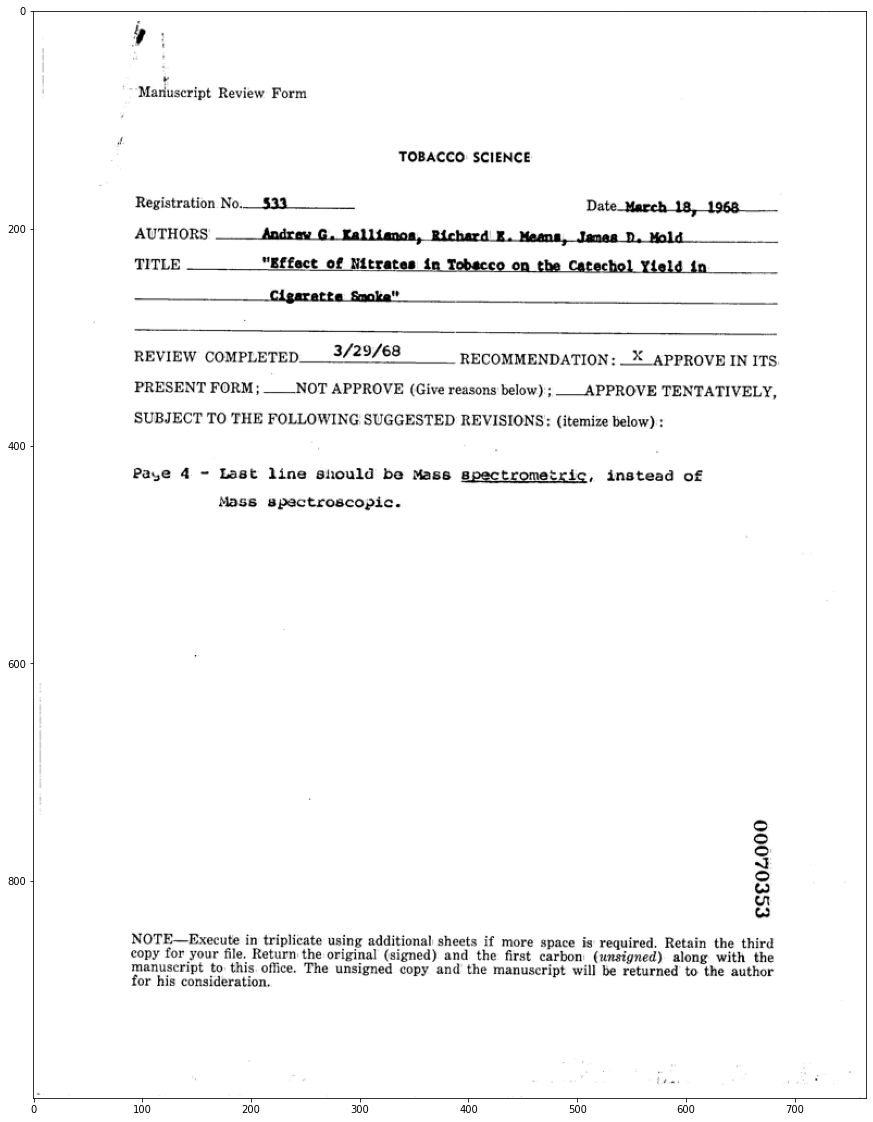

In [2]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/gdrive/My Drive/unilm/layoutlm/examples/seq_labeling/custom_data/training_data/Image/funsd_test_format8.png')
plt.figure(figsize = (30,20))  
plt.imshow(img)
plt.show()